### Feeder, Perch Ground Segmentation

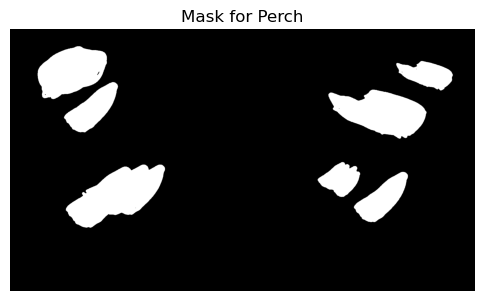

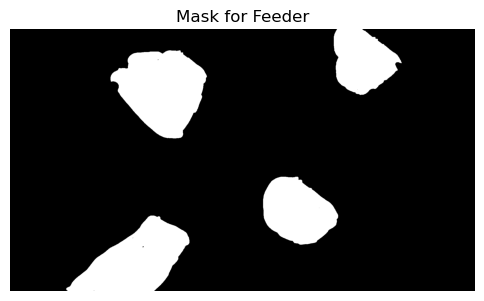

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

mask_image = cv2.imread('/parrot/extracted_frame_for_seg.jpg')
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

color_ranges = [
    ([51, 140, 130], "Perch"),  # RGB: Perch
    ([255, 140, 130], "Feeder")  # RGB: Feeder
]

mask_regions = {}

def is_color_within_range(pixel, target_rgb, tolerance=10):
    return np.all(np.abs(pixel - target_rgb) <= tolerance)

for target_rgb, label in color_ranges:
    mask_region = np.zeros(mask_image.shape[:2], dtype=bool)
    for i in range(mask_image.shape[0]):
        for j in range(mask_image.shape[1]):
            if is_color_within_range(mask_image[i, j], target_rgb):
                mask_region[i, j] = True 
    mask_regions[tuple(target_rgb)] = mask_region 

    plt.figure(figsize=(6, 6))
    plt.imshow(mask_region, cmap='gray') 
    plt.title(f'Mask for {label}')
    plt.axis('off')
    plt.show() 


### YOLO 학습

In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'

from ultralytics import YOLO

model = YOLO('yolov5su.pt')

results = model.train(
    data='/parrot/data_YOLO/data.yaml',
    epochs=200,             
    batch=32,  
    imgsz=640,  
    project='parrot',  
    name='parrot_object_detection', 
    device=5,
)

results.plot()

### YOLO 모델 예측하기

In [ ]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np

cap = cv2.VideoCapture("/parrot/input.mp4")


position = "Unknown"
mask_image = cv2.imread('/parrot/extracted_frame_for_seg.jpg')
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.resize(mask_image, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

color_ranges = [
    ([51, 140, 130], "Perch"),
    ([255, 140, 130], "Feeder")  
]

mask_regions = {}  

def is_color_within_range(pixel, target_rgb, tolerance=10):
    return np.all(np.abs(pixel - target_rgb) <= tolerance)

for target_rgb, label in color_ranges:
    mask_region = np.zeros(mask_image.shape[:2], dtype=bool)
    for i in range(mask_image.shape[0]):
        for j in range(mask_image.shape[1]):
            if is_color_within_range(mask_image[i, j], target_rgb):
                mask_region[i, j] = True 
    mask_regions[tuple(target_rgb)] = mask_region  

In [ ]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = YOLO('/parrot/parrot_object_detection/weights/best.pt')  
model.to(device) 

cap = cv2.VideoCapture("/parrot/input9.mp4")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output_video_path = '/parrot/output_video_with_detections6.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    
    boxes = results[0].boxes.xywh 
    confidences = results[0].boxes.conf  
    labels = results[0].boxes.cls  

    threshold = 0.6
    filtered_boxes = boxes[confidences > threshold]
    filtered_confidences = confidences[confidences > threshold]
    filtered_labels = labels[confidences > threshold]

    names = results[0].names
    filtered_labels_text = [names[int(label)] for label in filtered_labels]
#################################################################################################################################################
    for box, conf, label_text in zip(filtered_boxes, filtered_confidences, filtered_labels_text):
        x, y, w, h = box 
        x1, y1, x2, y2 = int(x - w / 2), int(y - h / 2), int(x + w / 2), int(y + h / 2) 
        
        color = (0, 255, 0)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        label_text = f"{label_text} {conf:.2f}"
        cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
#################################################################################################################################################
        aspect_ratio = w / h
        ratio_text = f"Aspect Ratio: {aspect_ratio:.2f}"

        cv2.putText(frame, ratio_text, (x1, y1 - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
#################################################################################################################################################
        bottom_center_x = min(max(x, 0), frame_width - 1)
        bottom_center_y = min(max(y + h / 2, 0), frame_height - 1)
        bottom_center = (int(bottom_center_x), int(bottom_center_y))

        cv2.circle(frame, bottom_center, 5, (0, 0, 255), -1)
        cv2.putText(frame, "Bottom Center", (bottom_center[0] + 10, bottom_center[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
#################################################################################################################################################
        for target_rgb, label in color_ranges:
            if mask_regions[tuple(target_rgb)][bottom_center[1], bottom_center[0]]:
                position = label
                break
            else:
                position = "Unknown"

        cv2.putText(frame, f"Position: {position}", (bottom_center[0] + 10, bottom_center[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()